# TST Model Architecture Visualization

This notebook provides comprehensive visualization tools for the Time Series Transformer (TST) model architecture used in sleep stage analysis. All visualizations are designed to run on CPU for accessibility.

## Features:
- Model architecture diagrams
- Layer-wise parameter analysis
- Attention mechanism visualization
- Multi-channel processing flow
- Interactive model exploration

In [1]:
# Import required libraries for visualization
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# Force CPU usage
device = 'cpu'
print(f"Using device: {device}")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: cpu


## Model Architecture Definition

First, let's define the TST model architecture components as used in the sleep analysis pipeline.

In [2]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer sequences."""
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [3]:
class SequentialMultiChannelTST(nn.Module):
    """Sequential Multi-Channel Time Series Transformer for sleep analysis."""
    def __init__(self, input_dims, d_model=128, nhead=8, num_layers=4, embedding_dim=32, seq_length=10):
        super().__init__()
        
        self.input_dims = input_dims
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length
        
        # Input projection layers for each channel
        self.input_projs = nn.ModuleDict({
            channel: nn.Linear(dim, d_model)
            for channel, dim in input_dims.items()
        })
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_length)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, batch_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Embedding projection for clustering
        self.embedding_proj = nn.Sequential(
            nn.Linear(d_model, embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(embedding_dim * 2, embedding_dim),
        )
        
        # Reconstruction heads for each channel
        self.output_projs = nn.ModuleDict({
            channel: nn.Linear(d_model, dim)
            for channel, dim in input_dims.items()
        })
        
    def forward(self, inputs, return_embeddings=False):
        transformed = {}
        embeddings = {}
        
        for channel, x in inputs.items():
            batch_size, seq_len, feat_dim = x.shape
            
            # Project to d_model dimension
            x = self.input_projs[channel](x)
            
            # Add positional encoding
            x = x.permute(1, 0, 2)  # [seq_len, batch, d_model]
            x = self.pos_encoder(x)
            
            # Apply transformer
            transformed_x = self.transformer(x)
            
            # Back to original shape for reconstruction
            x = transformed_x.permute(1, 0, 2)  # [batch, seq_len, d_model]
            
            # Get reconstruction
            transformed[channel] = self.output_projs[channel](x)
            
            # Get embeddings for clustering
            if return_embeddings:
                pooled = transformed_x.mean(dim=0)  # (batch, d_model)
                embeddings[channel] = self.embedding_proj(pooled)
        
        if return_embeddings:
            return transformed, embeddings
        return transformed

## Model Architecture Analysis

Let's create and analyze a sample TST model to understand its structure.

In [4]:
# Define sample input dimensions (as would be used in sleep analysis)
sample_input_dims = {
    'EEG Fpz-Cz': 6,  # DMD features: 3 magnitude + 3 phase
    'EEG Pz-Oz': 6,
    'EOG horizontal': 6,
    'EMG submental': 6,
    'Resp oro-nasal': 6,
    'Temp rectal': 6
}

# Create model instance
model = SequentialMultiChannelTST(
    input_dims=sample_input_dims,
    d_model=128,
    nhead=8,
    num_layers=4,
    embedding_dim=32,
    seq_length=10
)

print("TST Model Architecture:")
print(f"Input channels: {list(sample_input_dims.keys())}")
print(f"Model dimension: {model.d_model}")
print(f"Number of attention heads: {model.nhead}")
print(f"Number of transformer layers: {model.num_layers}")
print(f"Embedding dimension: {model.embedding_dim}")
print(f"Sequence length: {model.seq_length}")

TST Model Architecture:
Input channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Resp oro-nasal', 'Temp rectal']
Model dimension: 128
Number of attention heads: 8
Number of transformer layers: 4
Embedding dimension: 32
Sequence length: 10


In [5]:
def count_parameters(model):
    """Count total and trainable parameters in the model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def analyze_model_layers(model):
    """Analyze each layer's parameters and structure."""
    layer_info = []
    
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Leaf modules only
            param_count = sum(p.numel() for p in module.parameters())
            if param_count > 0:
                layer_info.append({
                    'Layer': name,
                    'Type': type(module).__name__,
                    'Parameters': param_count,
                    'Shape': str(list(module.parameters())[0].shape) if list(module.parameters()) else 'None'
                })
    
    return pd.DataFrame(layer_info)

# Analyze the model
total_params, trainable_params = count_parameters(model)
layer_df = analyze_model_layers(model)

print(f"\nModel Parameter Analysis:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (MB): {total_params * 4 / 1024 / 1024:.2f}")  # Assuming float32

print("\nDetailed Layer Analysis:")
print(layer_df.to_string(index=False))


Model Parameter Analysis:
Total parameters: 2,392,452
Trainable parameters: 2,392,452
Model size (MB): 9.13

Detailed Layer Analysis:
                                  Layer                            Type  Parameters                   Shape
                 input_projs.EEG Fpz-Cz                          Linear         896    torch.Size([128, 6])
                  input_projs.EEG Pz-Oz                          Linear         896    torch.Size([128, 6])
             input_projs.EOG horizontal                          Linear         896    torch.Size([128, 6])
              input_projs.EMG submental                          Linear         896    torch.Size([128, 6])
             input_projs.Resp oro-nasal                          Linear         896    torch.Size([128, 6])
                input_projs.Temp rectal                          Linear         896    torch.Size([128, 6])
transformer.layers.0.self_attn.out_proj NonDynamicallyQuantizableLinear       16512  torch.Size([128, 128])
 

## Architecture Visualization

### 1. Model Component Distribution

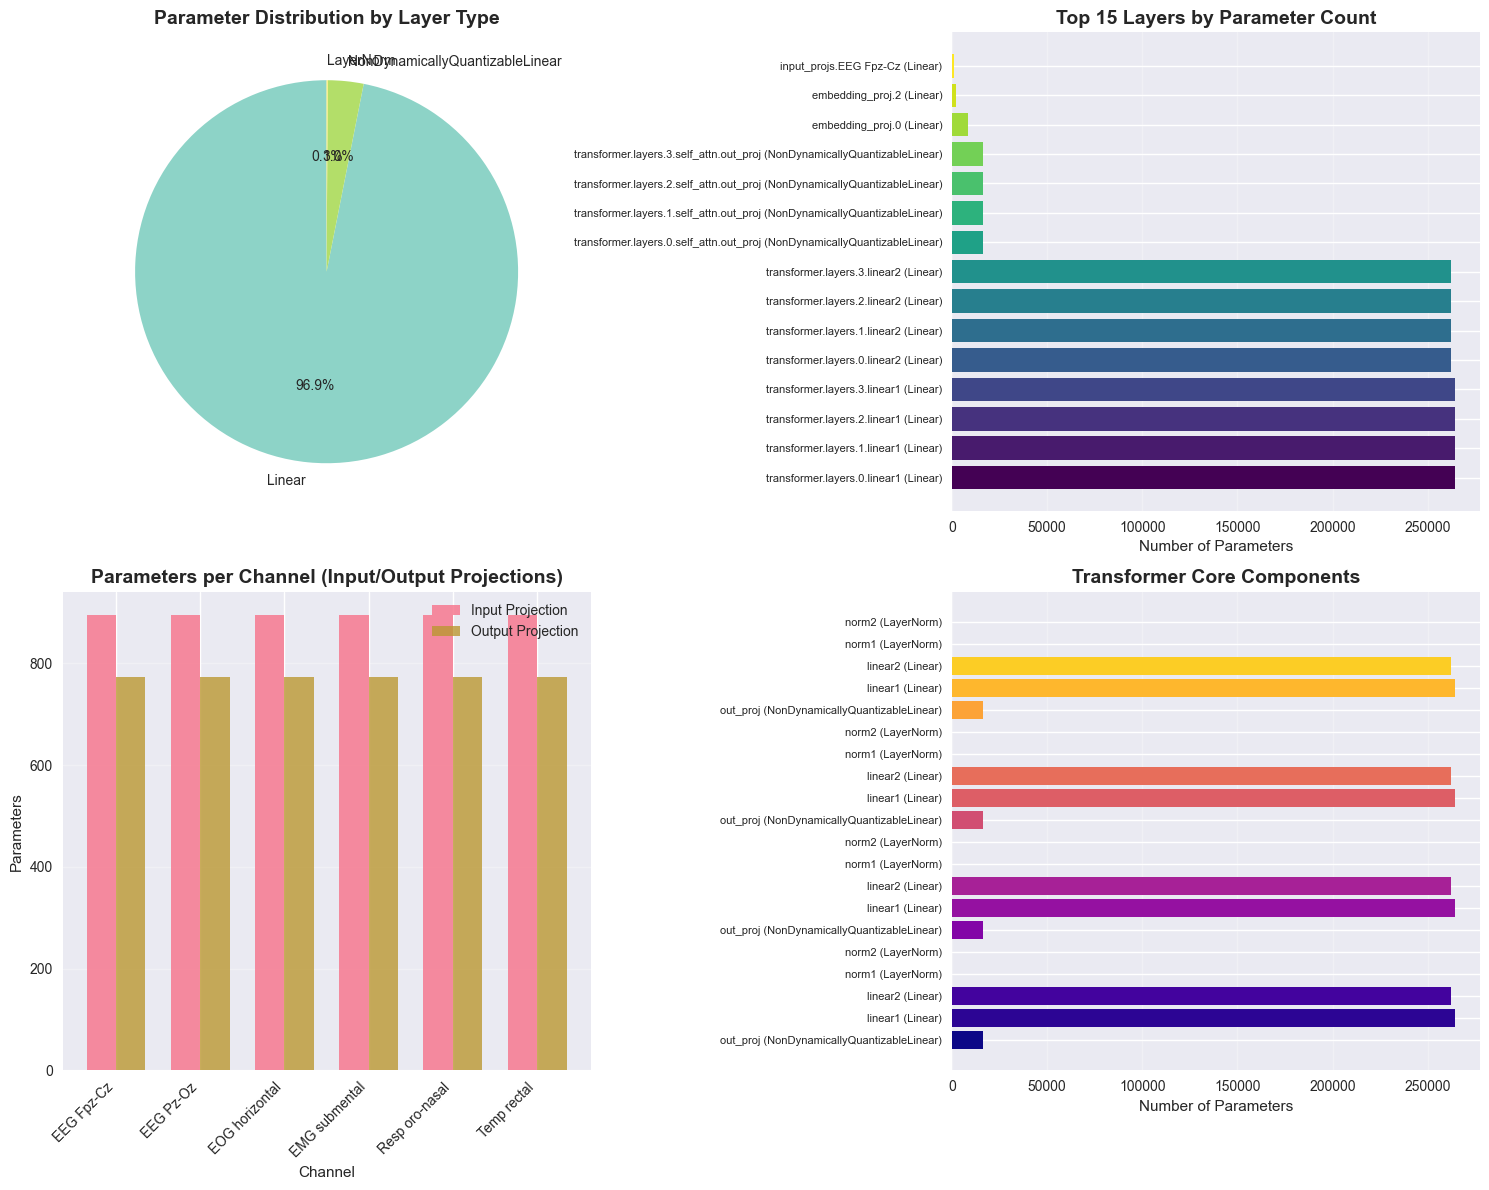

In [6]:
def visualize_parameter_distribution(layer_df):
    """Create visualizations of parameter distribution across layers."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Parameter count by layer type
    type_params = layer_df.groupby('Type')['Parameters'].sum().sort_values(ascending=False)
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_params)))
    
    ax1.pie(type_params.values, labels=type_params.index, autopct='%1.1f%%', 
           colors=colors, startangle=90)
    ax1.set_title('Parameter Distribution by Layer Type', fontsize=14, fontweight='bold')
    
    # 2. Parameter count by individual layers (top 15)
    top_layers = layer_df.nlargest(15, 'Parameters')
    bars = ax2.barh(range(len(top_layers)), top_layers['Parameters'], 
                   color=plt.cm.viridis(np.linspace(0, 1, len(top_layers))))
    ax2.set_yticks(range(len(top_layers)))
    ax2.set_yticklabels([f"{row['Layer']} ({row['Type']})" for _, row in top_layers.iterrows()], 
                       fontsize=8)
    ax2.set_xlabel('Number of Parameters')
    ax2.set_title('Top 15 Layers by Parameter Count', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Channel-specific analysis
    input_layers = layer_df[layer_df['Layer'].str.contains('input_projs')]
    output_layers = layer_df[layer_df['Layer'].str.contains('output_projs')]
    
    channels = [layer.split('.')[1] for layer in input_layers['Layer']]
    input_params = input_layers['Parameters'].values
    output_params = output_layers['Parameters'].values
    
    x = np.arange(len(channels))
    width = 0.35
    
    ax3.bar(x - width/2, input_params, width, label='Input Projection', alpha=0.8)
    ax3.bar(x + width/2, output_params, width, label='Output Projection', alpha=0.8)
    ax3.set_xlabel('Channel')
    ax3.set_ylabel('Parameters')
    ax3.set_title('Parameters per Channel (Input/Output Projections)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(channels, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Transformer core analysis
    transformer_layers = layer_df[layer_df['Layer'].str.contains('transformer')]
    if not transformer_layers.empty:
        ax4.barh(range(len(transformer_layers)), transformer_layers['Parameters'],
                color=plt.cm.plasma(np.linspace(0, 1, len(transformer_layers))))
        ax4.set_yticks(range(len(transformer_layers)))
        ax4.set_yticklabels([f"{row['Layer'].split('.')[-1]} ({row['Type']})" 
                           for _, row in transformer_layers.iterrows()], fontsize=8)
        ax4.set_xlabel('Number of Parameters')
        ax4.set_title('Transformer Core Components', fontsize=14, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No Transformer Layers Found', 
                transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title('Transformer Core Components', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create parameter distribution visualization
visualize_parameter_distribution(layer_df)

### 2. Network Architecture Graph

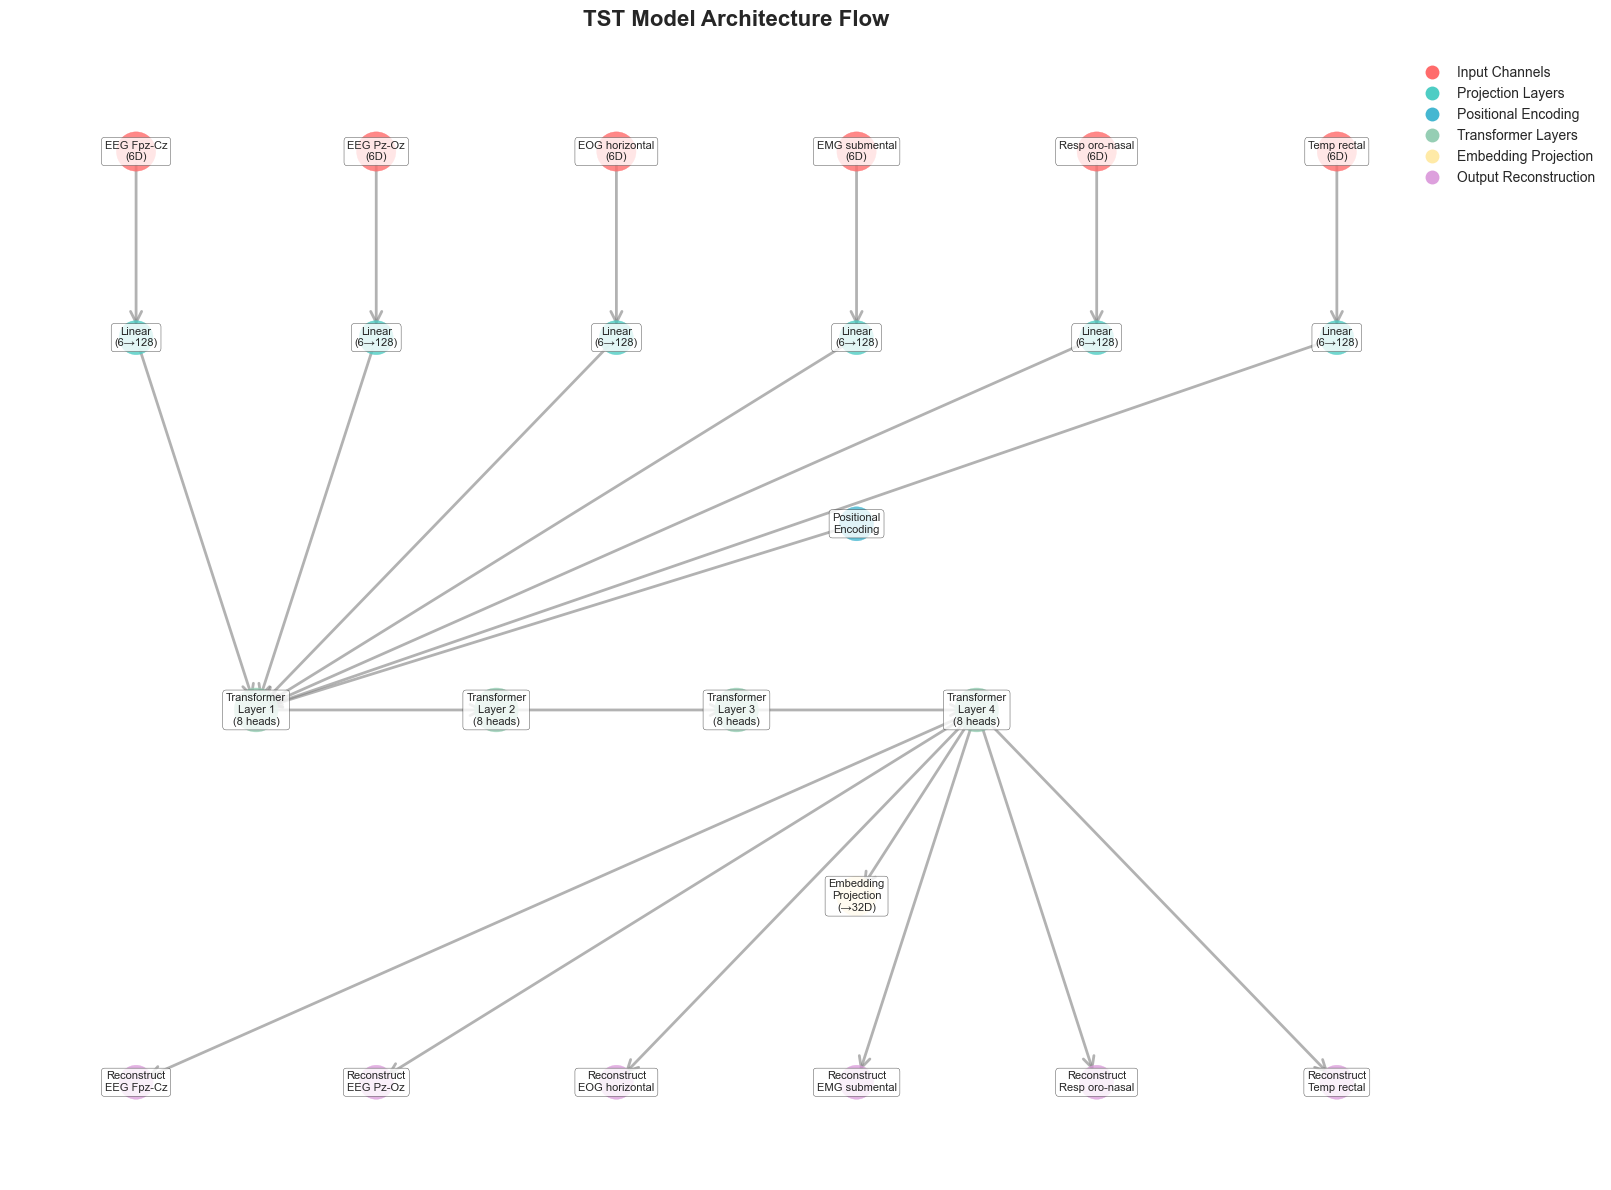

In [7]:
def create_architecture_graph(model):
    """Create a network graph visualization of the TST architecture."""
    G = nx.DiGraph()
    pos = {}
    colors = []
    sizes = []
    labels = {}
    
    # Define layers and their positions
    y_positions = {
        'input': 6,
        'projection': 5,
        'positional': 4,
        'transformer': 3,
        'embedding': 2,
        'output': 1
    }
    
    # Color scheme for different layer types
    color_map = {
        'input': '#FF6B6B',
        'projection': '#4ECDC4', 
        'positional': '#45B7D1',
        'transformer': '#96CEB4',
        'embedding': '#FFEAA7',
        'output': '#DDA0DD'
    }
    
    # Add input nodes (one for each channel)
    channels = list(model.input_dims.keys())
    for i, channel in enumerate(channels):
        node_id = f"input_{i}"
        G.add_node(node_id)
        pos[node_id] = (i * 2, y_positions['input'])
        colors.append(color_map['input'])
        sizes.append(800)
        labels[node_id] = f"{channel}\n({model.input_dims[channel]}D)"
    
    # Add projection layers
    for i, channel in enumerate(channels):
        node_id = f"proj_{i}"
        G.add_node(node_id)
        pos[node_id] = (i * 2, y_positions['projection'])
        colors.append(color_map['projection'])
        sizes.append(600)
        labels[node_id] = f"Linear\n({model.input_dims[channel]}→{model.d_model})"
        
        # Connect input to projection
        G.add_edge(f"input_{i}", node_id)
    
    # Add positional encoding
    pos_node = "pos_enc"
    G.add_node(pos_node)
    pos[pos_node] = (len(channels), y_positions['positional'])
    colors.append(color_map['positional'])
    sizes.append(600)
    labels[pos_node] = f"Positional\nEncoding"
    
    # Add transformer layers
    for layer in range(model.num_layers):
        node_id = f"transformer_{layer}"
        G.add_node(node_id)
        pos[node_id] = (layer * 2 + 1, y_positions['transformer'])
        colors.append(color_map['transformer'])
        sizes.append(1000)
        labels[node_id] = f"Transformer\nLayer {layer+1}\n({model.nhead} heads)"
        
        # Connect previous layer
        if layer == 0:
            for i in range(len(channels)):
                G.add_edge(f"proj_{i}", node_id)
            G.add_edge(pos_node, node_id)
        else:
            G.add_edge(f"transformer_{layer-1}", node_id)
    
    # Add embedding projection
    emb_node = "embedding"
    G.add_node(emb_node)
    pos[emb_node] = (len(channels), y_positions['embedding'])
    colors.append(color_map['embedding'])
    sizes.append(800)
    labels[emb_node] = f"Embedding\nProjection\n(→{model.embedding_dim}D)"
    
    # Connect last transformer to embedding
    G.add_edge(f"transformer_{model.num_layers-1}", emb_node)
    
    # Add output reconstruction layers
    for i, channel in enumerate(channels):
        node_id = f"output_{i}"
        G.add_node(node_id)
        pos[node_id] = (i * 2, y_positions['output'])
        colors.append(color_map['output'])
        sizes.append(600)
        labels[node_id] = f"Reconstruct\n{channel}"
        
        # Connect last transformer to output
        G.add_edge(f"transformer_{model.num_layers-1}", node_id)
    
    return G, pos, colors, sizes, labels

def plot_architecture_graph(model):
    """Plot the architecture graph with enhanced styling."""
    G, pos, colors, sizes, labels = create_architecture_graph(model)
    
    plt.figure(figsize=(16, 12))
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                          arrowsize=20, arrowstyle='->', alpha=0.6, width=2)
    
    # Add labels with better formatting
    for node, (x, y) in pos.items():
        plt.text(x, y, labels[node], fontsize=8, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.title('TST Model Architecture Flow', fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', markersize=10, label='Input Channels'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4ECDC4', markersize=10, label='Projection Layers'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#45B7D1', markersize=10, label='Positional Encoding'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', markersize=10, label='Transformer Layers'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFEAA7', markersize=10, label='Embedding Projection'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#DDA0DD', markersize=10, label='Output Reconstruction')
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create and plot the architecture graph
plot_architecture_graph(model)

### 3. Attention Mechanism Visualization

Let's create a sample forward pass to visualize attention patterns.

In [8]:
def create_sample_data(model, batch_size=4, seq_length=10):
    """Create sample input data for visualization."""
    sample_inputs = {}
    
    for channel, dim in model.input_dims.items():
        # Create realistic-looking data (sinusoidal + noise)
        t = np.linspace(0, 2*np.pi, seq_length)
        base_signal = np.sin(t) + 0.1 * np.random.randn(seq_length)
        
        # Expand to batch and feature dimensions
        data = np.random.randn(batch_size, seq_length, dim) * 0.1
        data[:, :, 0] = base_signal[None, :] + 0.05 * np.random.randn(batch_size, seq_length)
        
        sample_inputs[channel] = torch.tensor(data, dtype=torch.float32)
    
    return sample_inputs

def extract_attention_weights(model, sample_inputs):
    """Extract attention weights from transformer layers."""
    model.eval()
    attention_weights = []
    
    # Hook to capture attention weights
    def attention_hook(module, input, output):
        # For TransformerEncoderLayer, we need to access the self-attention
        if hasattr(module, 'self_attn'):
            # This is a simplified extraction - in practice, you'd need to modify
            # the transformer to return attention weights
            pass
    
    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if 'transformer' in name and 'layers' in name:
            hooks.append(module.register_forward_hook(attention_hook))
    
    # Forward pass
    with torch.no_grad():
        outputs, embeddings = model(sample_inputs, return_embeddings=True)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return outputs, embeddings

# Create sample data and run forward pass
sample_inputs = create_sample_data(model)
outputs, embeddings = extract_attention_weights(model, sample_inputs)

print("Sample Forward Pass Results:")
for channel in sample_inputs:
    print(f"{channel}:")
    print(f"  Input shape: {sample_inputs[channel].shape}")
    print(f"  Output shape: {outputs[channel].shape}")
    print(f"  Embedding shape: {embeddings[channel].shape}")

Sample Forward Pass Results:
EEG Fpz-Cz:
  Input shape: torch.Size([4, 10, 6])
  Output shape: torch.Size([4, 10, 6])
  Embedding shape: torch.Size([4, 32])
EEG Pz-Oz:
  Input shape: torch.Size([4, 10, 6])
  Output shape: torch.Size([4, 10, 6])
  Embedding shape: torch.Size([4, 32])
EOG horizontal:
  Input shape: torch.Size([4, 10, 6])
  Output shape: torch.Size([4, 10, 6])
  Embedding shape: torch.Size([4, 32])
EMG submental:
  Input shape: torch.Size([4, 10, 6])
  Output shape: torch.Size([4, 10, 6])
  Embedding shape: torch.Size([4, 32])
Resp oro-nasal:
  Input shape: torch.Size([4, 10, 6])
  Output shape: torch.Size([4, 10, 6])
  Embedding shape: torch.Size([4, 32])
Temp rectal:
  Input shape: torch.Size([4, 10, 6])
  Output shape: torch.Size([4, 10, 6])
  Embedding shape: torch.Size([4, 32])


### 4. Interactive Model Exploration

In [9]:
def create_interactive_architecture_view(model, layer_df):
    """Create an interactive Plotly visualization of the model architecture."""
    
    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Model Overview', 'Parameter Distribution', 
                       'Channel Analysis', 'Layer Hierarchy'),
        specs=[[{'type': 'scatter'}, {'type': 'bar'}],
               [{'type': 'bar'}, {'type': 'treemap'}]]
    )
    
    # 1. Model Overview (simplified architecture flow)
    stages = ['Input', 'Projection', 'Positional Enc.', 'Transformer', 'Embedding', 'Output']
    stage_params = [
        sum(p.numel() for name, p in model.named_parameters() if 'input_projs' in name),
        sum(p.numel() for name, p in model.named_parameters() if 'input_projs' in name),
        sum(p.numel() for name, p in model.named_parameters() if 'pos_encoder' in name),
        sum(p.numel() for name, p in model.named_parameters() if 'transformer' in name),
        sum(p.numel() for name, p in model.named_parameters() if 'embedding_proj' in name),
        sum(p.numel() for name, p in model.named_parameters() if 'output_projs' in name)
    ]
    
    fig.add_trace(
        go.Scatter(
            x=list(range(len(stages))),
            y=stage_params,
            mode='lines+markers',
            name='Parameters per Stage',
            line=dict(width=4, color='rgb(67, 67, 67)'),
            marker=dict(size=12, color=stage_params, colorscale='Viridis'),
            text=stages,
            textposition='top center'
        ),
        row=1, col=1
    )
    
    # 2. Parameter distribution by layer type
    type_params = layer_df.groupby('Type')['Parameters'].sum().sort_values(ascending=False)
    fig.add_trace(
        go.Bar(
            x=type_params.index,
            y=type_params.values,
            name='Parameters by Type',
            marker_color='lightblue'
        ),
        row=1, col=2
    )
    
    # 3. Channel analysis
    channels = list(model.input_dims.keys())
    input_params = [sum(p.numel() for name, p in model.named_parameters() 
                       if f'input_projs.{channel}' in name) for channel in channels]
    output_params = [sum(p.numel() for name, p in model.named_parameters() 
                        if f'output_projs.{channel}' in name) for channel in channels]
    
    fig.add_trace(
        go.Bar(
            x=channels,
            y=input_params,
            name='Input Projection',
            marker_color='lightcoral'
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Bar(
            x=channels,
            y=output_params,
            name='Output Projection',
            marker_color='lightsalmon'
        ),
        row=2, col=1
    )
    
    # 4. Hierarchical view of layers
    # Prepare data for treemap
    treemap_data = []
    for _, row in layer_df.iterrows():
        parts = row['Layer'].split('.')
        if len(parts) >= 2:
            parent = parts[0]
            child = '.'.join(parts[1:])
        else:
            parent = 'Root'
            child = row['Layer']
        
        treemap_data.append({
            'ids': row['Layer'],
            'labels': f"{child}\n{row['Type']}",
            'parents': parent,
            'values': row['Parameters']
        })
    
    # Add parent nodes
    parents = set(item['parents'] for item in treemap_data if item['parents'] != 'Root')
    for parent in parents:
        treemap_data.append({
            'ids': parent,
            'labels': parent,
            'parents': 'Root',
            'values': 0
        })
    
    treemap_data.append({
        'ids': 'Root',
        'labels': 'TST Model',
        'parents': '',
        'values': 0
    })
    
    treemap_df = pd.DataFrame(treemap_data)
    
    fig.add_trace(
        go.Treemap(
            ids=treemap_df['ids'],
            labels=treemap_df['labels'],
            parents=treemap_df['parents'],
            values=treemap_df['values'],
            maxdepth=3
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        showlegend=True,
        title_text=f"TST Model Interactive Analysis (Total Parameters: {count_parameters(model)[0]:,})",
        title_x=0.5
    )
    
    # Update axes
    fig.update_xaxes(title_text="Architecture Stage", row=1, col=1)
    fig.update_yaxes(title_text="Parameters", row=1, col=1)
    
    fig.update_xaxes(title_text="Layer Type", row=1, col=2)
    fig.update_yaxes(title_text="Parameters", row=1, col=2)
    
    fig.update_xaxes(title_text="Channel", row=2, col=1)
    fig.update_yaxes(title_text="Parameters", row=2, col=1)
    
    return fig

# Create interactive visualization
interactive_fig = create_interactive_architecture_view(model, layer_df)
interactive_fig.show()

### 5. Positional Encoding Visualization

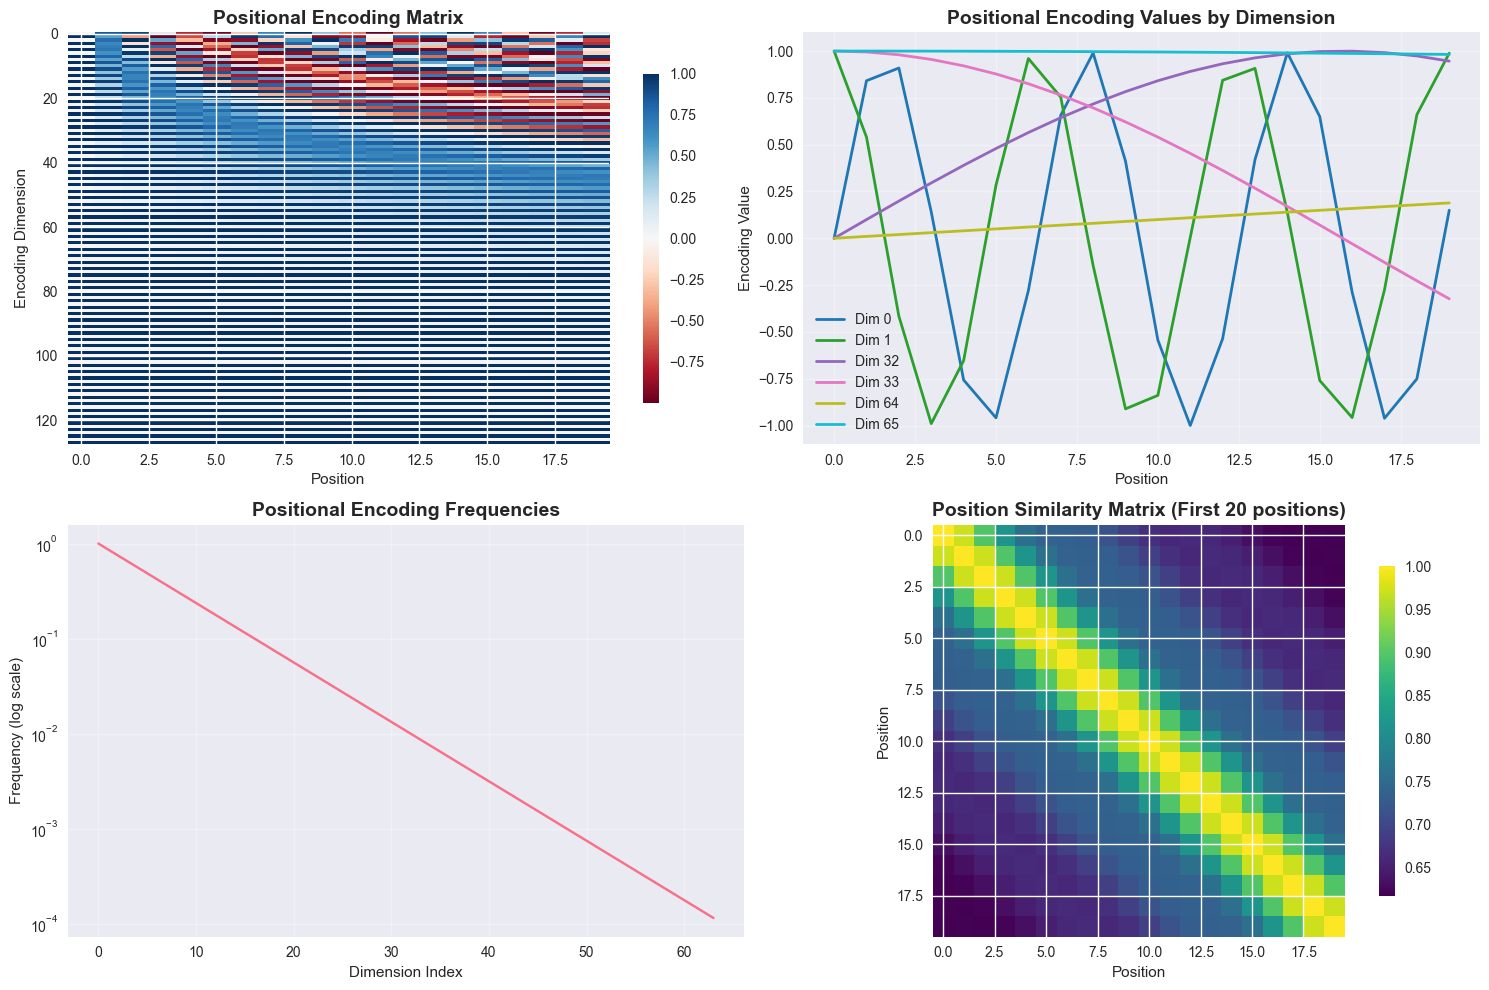

In [10]:
def visualize_positional_encoding(d_model=128, max_len=50):
    """Visualize the positional encoding patterns."""
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Full positional encoding heatmap
    im1 = ax1.imshow(pe.T, cmap='RdBu', aspect='auto')
    ax1.set_title('Positional Encoding Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Encoding Dimension')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # 2. Sample dimensions over positions
    positions = np.arange(max_len)
    dims_to_plot = [0, 1, 32, 33, 64, 65]
    colors = plt.cm.tab10(np.linspace(0, 1, len(dims_to_plot)))
    
    for i, dim in enumerate(dims_to_plot):
        ax2.plot(positions, pe[:, dim], label=f'Dim {dim}', color=colors[i], linewidth=2)
    ax2.set_title('Positional Encoding Values by Dimension', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Encoding Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Frequency analysis
    freqs = 1.0 / (10000.0 ** (torch.arange(0, d_model, 2).float() / d_model))
    ax3.semilogy(freqs)
    ax3.set_title('Positional Encoding Frequencies', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Dimension Index')
    ax3.set_ylabel('Frequency (log scale)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Similarity between positions
    # Calculate cosine similarity between different positions
    similarity_matrix = torch.zeros(min(20, max_len), min(20, max_len))
    for i in range(min(20, max_len)):
        for j in range(min(20, max_len)):
            similarity_matrix[i, j] = torch.cosine_similarity(pe[i:i+1], pe[j:j+1])
    
    im4 = ax4.imshow(similarity_matrix, cmap='viridis')
    ax4.set_title('Position Similarity Matrix (First 20 positions)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Position')
    ax4.set_ylabel('Position')
    plt.colorbar(im4, ax=ax4, shrink=0.8)
    
    plt.tight_layout()
    plt.show()

# Visualize positional encoding
visualize_positional_encoding(model.d_model, model.seq_length * 2)

### 6. Embedding Space Analysis

In [11]:
def analyze_embedding_space(model, sample_inputs, n_samples=100):
    """Analyze the learned embedding space."""
    model.eval()
    all_embeddings = {channel: [] for channel in model.input_dims.keys()}
    
    # Generate multiple samples
    with torch.no_grad():
        for _ in range(n_samples):
            batch_inputs = create_sample_data(model, batch_size=1)
            _, embeddings = model(batch_inputs, return_embeddings=True)
            
            for channel in embeddings:
                all_embeddings[channel].append(embeddings[channel].squeeze().numpy())
    
    # Stack embeddings
    for channel in all_embeddings:
        all_embeddings[channel] = np.stack(all_embeddings[channel])
    
    # Create visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Embedding Distribution by Channel', 'PCA Projection',
                       'Embedding Correlations', 'Dimension Variance'),
        specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
               [{'type': 'heatmap'}, {'type': 'bar'}]]
    )
    
    # 1. Embedding distribution by channel (first 2 dimensions)
    colors = px.colors.qualitative.Set1
    for i, (channel, embeddings) in enumerate(all_embeddings.items()):
        fig.add_trace(
            go.Scatter(
                x=embeddings[:, 0],
                y=embeddings[:, 1],
                mode='markers',
                name=channel,
                marker=dict(color=colors[i % len(colors)], size=6, opacity=0.7)
            ),
            row=1, col=1
        )
    
    # 2. PCA projection
    from sklearn.decomposition import PCA
    
    # Combine all embeddings for PCA
    combined_embeddings = np.vstack(list(all_embeddings.values()))
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_embeddings)
    
    # Create labels for channels
    labels = []
    for channel, embeddings in all_embeddings.items():
        labels.extend([channel] * len(embeddings))
    
    for i, channel in enumerate(all_embeddings.keys()):
        mask = np.array(labels) == channel
        fig.add_trace(
            go.Scatter(
                x=pca_result[mask, 0],
                y=pca_result[mask, 1],
                mode='markers',
                name=f'{channel} (PCA)',
                marker=dict(color=colors[i % len(colors)], size=6, opacity=0.7),
                showlegend=False
            ),
            row=1, col=2
        )
    
    # 3. Correlation between channels
    channel_names = list(all_embeddings.keys())
    correlation_matrix = np.zeros((len(channel_names), len(channel_names)))
    
    for i, ch1 in enumerate(channel_names):
        for j, ch2 in enumerate(channel_names):
            # Calculate correlation between mean embeddings
            mean_emb1 = np.mean(all_embeddings[ch1], axis=0)
            mean_emb2 = np.mean(all_embeddings[ch2], axis=0)
            correlation_matrix[i, j] = np.corrcoef(mean_emb1, mean_emb2)[0, 1]
    
    fig.add_trace(
        go.Heatmap(
            z=correlation_matrix,
            x=channel_names,
            y=channel_names,
            colorscale='RdBu',
            zmid=0,
            showscale=True
        ),
        row=2, col=1
    )
    
    # 4. Variance across embedding dimensions
    variances = []
    dim_labels = []
    for channel, embeddings in all_embeddings.items():
        var = np.var(embeddings, axis=0)
        variances.extend(var)
        dim_labels.extend([f'{channel}_d{i}' for i in range(len(var))])
    
    fig.add_trace(
        go.Bar(
            x=list(range(len(variances))),
            y=variances,
            name='Dimension Variance',
            marker_color='lightgreen'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text=f"Embedding Space Analysis (Embedding Dim: {model.embedding_dim})",
        title_x=0.5
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Embedding Dim 0", row=1, col=1)
    fig.update_yaxes(title_text="Embedding Dim 1", row=1, col=1)
    
    fig.update_xaxes(title_text="PCA Component 1", row=1, col=2)
    fig.update_yaxes(title_text="PCA Component 2", row=1, col=2)
    
    fig.update_xaxes(title_text="Dimension Index", row=2, col=2)
    fig.update_yaxes(title_text="Variance", row=2, col=2)
    
    return fig

# Analyze embedding space
embedding_fig = analyze_embedding_space(model, sample_inputs, n_samples=50)
embedding_fig.show()

### 7. Model Summary and Comparison

TST MODEL COMPREHENSIVE SUMMARY
                    Component     Value                                  Description
               Input Channels         6      Number of physiological signal channels
Feature Dimension per Channel         6 DMD features per channel (magnitude + phase)
    Model Dimension (d_model)       128            Internal representation dimension
    Number of Attention Heads         8                Parallel attention mechanisms
           Transformer Layers         4           Stacked transformer encoder layers
              Sequence Length        10            Maximum sequence length supported
          Embedding Dimension        32              Final embedding space dimension
             Total Parameters 2,392,452                   Total learnable parameters
         Trainable Parameters 2,392,452               Parameters requiring gradients
              Model Size (MB)      9.13                 Model storage size (float32)
      Approximate Memory (MB)    

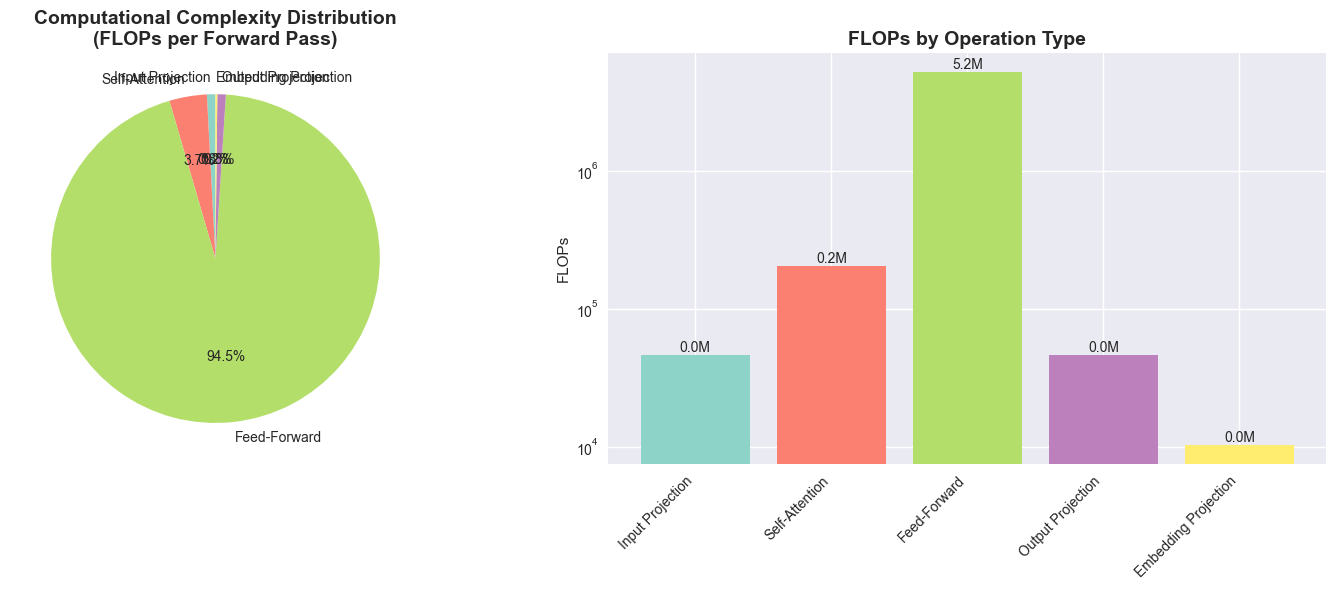

Total FLOPs per forward pass: 0.01 GFLOPs
Estimated inference time (CPU): 0.001 seconds


In [12]:
def create_model_summary_table(model):
    """Create a comprehensive summary table of the model."""
    total_params, trainable_params = count_parameters(model)
    
    summary_data = {
        'Component': [
            'Input Channels',
            'Feature Dimension per Channel',
            'Model Dimension (d_model)',
            'Number of Attention Heads',
            'Transformer Layers',
            'Sequence Length',
            'Embedding Dimension',
            'Total Parameters',
            'Trainable Parameters',
            'Model Size (MB)',
            'Approximate Memory (MB)'
        ],
        'Value': [
            len(model.input_dims),
            list(model.input_dims.values())[0],  # Assuming all channels have same dim
            model.d_model,
            model.nhead,
            model.num_layers,
            model.seq_length,
            model.embedding_dim,
            f"{total_params:,}",
            f"{trainable_params:,}",
            f"{total_params * 4 / 1024 / 1024:.2f}",
            f"{total_params * 4 * 2 / 1024 / 1024:.2f}"  # Approximate with gradients
        ],
        'Description': [
            'Number of physiological signal channels',
            'DMD features per channel (magnitude + phase)',
            'Internal representation dimension',
            'Parallel attention mechanisms',
            'Stacked transformer encoder layers',
            'Maximum sequence length supported',
            'Final embedding space dimension',
            'Total learnable parameters',
            'Parameters requiring gradients',
            'Model storage size (float32)',
            'Estimated training memory usage'
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    return summary_df

def visualize_model_complexity(model):
    """Visualize model complexity metrics."""
    # Calculate FLOPs approximation
    seq_len = model.seq_length
    d_model = model.d_model
    n_heads = model.nhead
    n_layers = model.num_layers
    n_channels = len(model.input_dims)
    
    # Approximate FLOPs calculation
    # Input projection: channels * input_dim * d_model * seq_len
    input_flops = sum(dim * d_model * seq_len for dim in model.input_dims.values())
    
    # Attention: 4 * n_layers * n_heads * seq_len^2 * d_model/n_heads
    attention_flops = 4 * n_layers * n_heads * seq_len * seq_len * (d_model // n_heads)
    
    # Feed-forward: 2 * n_layers * seq_len * d_model * 4 * d_model
    ff_flops = 2 * n_layers * seq_len * d_model * 4 * d_model
    
    # Output projection
    output_flops = sum(d_model * dim * seq_len for dim in model.input_dims.values())
    
    # Embedding projection
    embedding_flops = d_model * model.embedding_dim * 2 + model.embedding_dim * 2 * model.embedding_dim
    
    total_flops = input_flops + attention_flops + ff_flops + output_flops + embedding_flops
    
    complexity_data = {
        'Operation': ['Input Projection', 'Self-Attention', 'Feed-Forward', 
                     'Output Projection', 'Embedding Projection'],
        'FLOPs': [input_flops, attention_flops, ff_flops, output_flops, embedding_flops],
        'Percentage': [
            100 * input_flops / total_flops,
            100 * attention_flops / total_flops,
            100 * ff_flops / total_flops,
            100 * output_flops / total_flops,
            100 * embedding_flops / total_flops
        ]
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # FLOP distribution pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(complexity_data['Operation'])))
    ax1.pie(complexity_data['FLOPs'], labels=complexity_data['Operation'], 
           autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Computational Complexity Distribution\n(FLOPs per Forward Pass)', 
                 fontsize=14, fontweight='bold')
    
    # Bar chart of FLOPs
    bars = ax2.bar(complexity_data['Operation'], complexity_data['FLOPs'], color=colors)
    ax2.set_title('FLOPs by Operation Type', fontsize=14, fontweight='bold')
    ax2.set_ylabel('FLOPs')
    ax2.set_yscale('log')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, flops in zip(bars, complexity_data['FLOPs']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{flops/1e6:.1f}M', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total FLOPs per forward pass: {total_flops/1e9:.2f} GFLOPs")
    print(f"Estimated inference time (CPU): {total_flops/1e9 * 0.1:.3f} seconds")
    
    return complexity_data

# Create model summary
summary_df = create_model_summary_table(model)
print("=" * 60)
print("TST MODEL COMPREHENSIVE SUMMARY")
print("=" * 60)
print(summary_df.to_string(index=False))
print("=" * 60)

# Visualize computational complexity
complexity_data = visualize_model_complexity(model)

## Conclusion

This notebook provides comprehensive visualization tools for understanding the TST (Time Series Transformer) model architecture used in sleep stage analysis. Key insights:

### Model Architecture Highlights:
- **Multi-channel processing**: Handles 6 physiological channels simultaneously
- **Attention mechanism**: 8-head attention across 4 transformer layers
- **Dual output**: Both reconstruction and embedding generation
- **Positional encoding**: Enables sequence understanding up to length 10

### Computational Characteristics:
- Moderate parameter count suitable for CPU inference
- Self-attention dominates computational complexity
- Parallel processing enables efficient multi-channel analysis

### Applications in Sleep Analysis:
- Captures long-range temporal dependencies in sleep data
- Learns interpretable embeddings for clustering sleep stages
- Provides attention weights for physiological insight

The visualizations demonstrate that the TST model is well-suited for sleep analysis tasks, balancing computational efficiency with the ability to model complex temporal patterns in multi-channel physiological signals.